In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-09-20 03:18:19.103325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 03:18:19.103358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 03:18:19.108129: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 03:18:19.515215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-09-20 03:18:23.861705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 03:18:23.933089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 03:18:23.933321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Datos

In [3]:
## function to load images
def load_binary_images(file_names):  
    image = np.load(file_names).astype(np.float32)
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])   
    ## binariazar
    image = tf.where(image > 0.5, 1.0, 0.0)  
    return image

def load_images(file_names):
    image = np.load(file_names).astype(np.float32)
    #expand_dims
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])/255.0    
      
    return image

def min_max_scaler(ruta,image):
    ## load images in the path
    images = glob.glob(ruta + '/*.npy')
    images = sorted(images)
    ## load images
    images = [load_images(image) for image in images]
    ## min max scaler of thei image using the max and min of all images
    images = np.array(images)
    max_value = np.max(images)
    min_value = np.min(images)
    image = tf.math.abs((image - min_value)/(max_value - min_value))
    return image   

## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    #binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

## function to get geometric_attributes
def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')                

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter)]
        
        descriptors.append(descriptor)
        
    
    return descriptors

## function to get the middle image route in the folder
def get_middle_image(folder_route):
    ## get list of images
    images = glob.glob(folder_route + '/*.npy')
    ## order images
    images = sorted(images)
    ## get index of middle image
    if len(images) == 0:
        indx = -1
        middle_image = 'empty'
    else:
        indx = len(images)//2
        middle_image = images[indx]   
    
    return middle_image

In [4]:
## annotations to get nodule_features
annotations_cvs_4R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_3R.csv')
annotations_csv_3R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_4R.csv')
annotations = pd.concat([annotations_cvs_4R, annotations_csv_3R], ignore_index=True)
## drop malignancy = 3
annotations = annotations[annotations['malignancy'] != 3]
annotations

,patient_id,nodule_no,folder,malignancy,is_cancer,calcification,lobulation,texture,spiculation,subtlety,margin,intercept,slope
0,34,0,LICD-0034_NI000,2,False,6,1,5,1,5,5,-1024.0,1.0
1,45,2,LICD-0045_NI002,4,True,6,4,5,4,4,4,-1024.0,1.0
2,58,0,LICD-0058_NI000,5,True,6,3,5,5,5,4,-1024.0,1.0
3,72,0,LICD-0072_NI000,5,True,6,3,4,4,5,3,-1024.0,1.0
4,75,1,LICD-0075_NI001,5,True,6,3,5,5,5,4,-1024.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,1007,0,LICD-1007_NI000,2,False,6,1,5,1,3,4,-1024.0,1.0
917,1011,0,LICD-1011_NI000,4,True,6,1,4,4,5,4,-1024.0,1.0
918,1011,1,LICD-1011_NI001,5,True,6,3,5,2,5,4,-1024.0,1.0
919,1011,2,LICD-1011_NI002,5,True,6,3,5,3,5,3,-1024.0,1.0


In [5]:
## ruta dataset
rutas_images_npy = glob.glob('/data/Datasets/Nodules_ISBI/images/*/*.npy')

## order list by folder
rutas_images_npy = sorted(rutas_images_npy)

## get list of folders
folders = [ruta.split('/')[-2] for ruta in rutas_images_npy]
folders = np.unique(folders)

## build dataframe
rutas_images = []
rutas_masks = []
areas = []
perimetros = []
diametros = []
calsifications = []
spiculations = []
lobulations = []
sphericities = []
textures = []
margins = []
subletys = []

## cancer or not
labels = []
    
for folder in folders:
    ruta = '/data/Datasets/Nodules_ISBI/images/' + folder
    ruta_masc = '/data/Datasets/Nodules_ISBI/masks/' + folder
    
    ## load middle image route
    image_route = get_middle_image(ruta)
    name_image = image_route.split('/')[-1]
    mask_route = ruta_masc + '/' + name_image       
    
    if image_route != 'empty':    
        ## get attributes
        image = load_images(image_route)
        ## min-max scaler
        image = min_max_scaler(ruta, image)
        ## binary image
        binary_image = load_binary_images(mask_route)   
        ## get features of the image            
        features = annotations[annotations['folder'] == folder]
        if features.shape[0] != 0:     
            ## append rutas
            geometric_attributes = get_geometric_atributes([binary_image])[0]
            rutas_images.append(image_route)
            rutas_masks.append(mask_route)
            
            ## append attributes
            areas.append(geometric_attributes[0])
            perimetros.append(geometric_attributes[1])
            diametros.append(geometric_attributes[2])    
            
            ## evaluar si son nan e iomprimir solo si los  
              
            malignancy = features['malignancy'].values[0]
            calsification = features['calcification'].values[0]
            spiculation = features['spiculation'].values[0]
            lobulation = features['lobulation'].values[0]
            texture = features['texture'].values[0]
            label = features['is_cancer'].values[0]
            margin = features['margin'].values[0]
            sublety = features['subtlety'].values[0]
            
            ## append featuresprint(features)
            calsifications.append(calsification)
            spiculations.append(spiculation)
            lobulations.append(lobulation)
            textures.append(texture)
            labels.append(label)
            margins.append(margin)
            subletys.append(sublety)


## build dataframe
df = pd.DataFrame()
df['ruta'] = rutas_images
df['mask'] = rutas_masks
df['area'] = areas
df['perimetro'] = perimetros
df['diametro'] = diametros
df['calsification'] = calsifications
df['spiculation'] = spiculations
df['lobulation'] = lobulations
df['texture'] = textures
df['margin'] = margins
df['sublety'] = subletys
df['label'] = labels

df

2024-09-20 03:22:45.179603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 03:22:45.181049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 03:22:45.181221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,ruta,mask,area,perimetro,diametro,calsification,spiculation,lobulation,texture,margin,sublety,label
0,/data/Datasets/Nodules_ISBI/images/LICD-0001_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0001_NI...,128.5,49.213203,12.791063,6,5,3,5,4,5,True
1,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,86.0,36.970562,10.464158,6,3,2,4,3,5,True
2,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,39.5,24.727922,7.091753,6,2,2,5,4,4,True
3,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,50.0,26.970562,7.978846,6,1,1,5,5,4,True
4,/data/Datasets/Nodules_ISBI/images/LICD-0004_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0004_NI...,10.5,14.242641,3.656366,3,1,1,5,5,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
528,/data/Datasets/Nodules_ISBI/images/LICD-1007_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1007_NI...,16.0,16.485281,4.513517,6,1,1,5,4,3,False
529,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,117.5,43.556349,12.231339,6,4,1,4,4,5,True
530,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,70.5,36.384776,9.474354,6,2,3,5,4,5,True
531,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,81.5,35.213203,10.186708,6,3,3,5,3,5,True


# Dataset

In [6]:
## shuffle data
df_train_1, df_test = train_test_split(df, test_size=0.2, random_state=42)

## validation split
val_pctg = 0.8
split_validation_index = int(df_train_1.shape[0]*val_pctg)
df_train = df_train_1.iloc[:split_validation_index]
df_validation = df_train_1.iloc[split_validation_index:]

print('---- Distribución de entrenamiento, validación y test para benignos y malignos ----')
print('Malignos: ')
print('Positive train shape: ', df_train[df_train['label'] == 'True'].shape[0])
print('Positive val shape: ', df_validation[df_validation['label'] == 'True'].shape[0])
print('Positive test shape: ', df_test[df_test['label'] == 'True'].shape[0])

print('Benignos: ')
print('Negative train shape: ', df_train[df_train['label'] == 'False'].shape[0])
print('Negative val shape: ', df_validation[df_validation['label'] == 'False'].shape[0])
print('Negative test shape: ', df_test[df_test['label'] == 'False'].shape[0])

## drop na
df_train = df_train.dropna()
df_test = df_test.dropna()
df_validation = df_validation.dropna()

## replace labels
df_train.loc[:, 'label'] = df_train['label'].replace({'True': 1, 'False': 0})
df_test.loc[:, 'label'] = df_test['label'].replace({'True': 1, 'False': 0})
df_validation.loc[:, 'label'] = df_validation['label'].replace({'True': 1, 'False': 0})

print('---- Dataset finales ----')
print('Train shape: ', df_train.shape[0])
print('Test shape: ', df_test.shape[0])
print('Validation shape: ', df_validation.shape[0])

---- Distribución de entrenamiento, validación y test para benignos y malignos ----
Malignos: 
Positive train shape:  227
Positive val shape:  59
Positive test shape:  73
Benignos: 
Negative train shape:  113
Negative val shape:  27
Negative test shape:  34
---- Dataset finales ----
Train shape:  339
Test shape:  107
Validation shape:  85


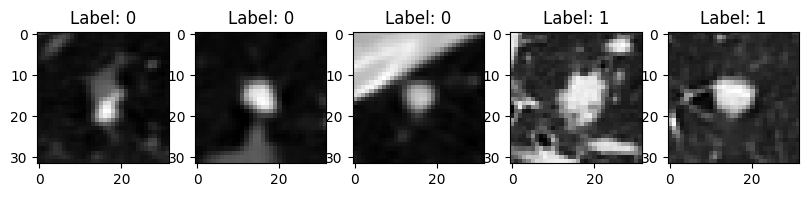

In [7]:
## plot 5 first images with mas on the df train dataset
plt.figure(figsize=(20,10))
for i in range(5):
    image = load_images(df_train['ruta'].values[i])    
    plt.subplot(1,10,i+1)
    plt.imshow(image, cmap='gray')   
    plt.title('Label: ' + str(df_train['label'].values[i]))

In [32]:
features_to_use = ['area','perimetro','lobulation', 'texture', 'spiculation', 'margin']


def create_train_dataset(batch,df):
    images_routes = df['ruta'].to_numpy()
    mask_routes = df['mask'].to_numpy()
    labels = df['label'].to_numpy()
    features = df[features_to_use].to_numpy()
    
    
    ## Data augmentation    
    def rotate90_image(image):
        ## rotate 90 degrees
        image = tf.image.rot90(image)
        return image
    
    def rotate180_image(arg):
        ## rotate 180 degrees
        image = tf.image.rot90(arg, k=2)
        return image
    
    def rotate270_image(arg):
        ## rotate 270 degrees
        image = tf.image.rot90(arg, k=3)
        return image
    
    images = []
    mask = []
    new_labels = []
    new_features = []
    for image_route, mask_route, label, features in zip(images_routes,mask_routes, labels,features):
        ## imagenes y mascaras originales
        image_original = load_images(image_route)
        mask_original = load_binary_images(mask_route)
        
        ## augmentaciones
        # imagen original
        #image_left_flip = flip_left_image(image_original)
        image_rotate90 = rotate90_image(image_original)
        image_rotate180 = rotate180_image(image_original)
        image_rotate270 = rotate270_image(image_original)
        #image_up_flip = flip_up_image(image_original)
        ## mascara original
        #mask_left_flip = flip_left_image(mask_original)
        mask_rotate90 = rotate90_image(mask_original)
        mask_rotate180 = rotate180_image(mask_original)
        mask_rotate270 = rotate270_image(mask_original)
        #mask_up_flip = flip_up_image(mask_original)
        
        ## append image augmentation
        images.append(image_original)        
        images.append(image_rotate90)
        images.append(image_rotate180)
        images.append(image_rotate270)
        
        
        ## append mask augmentation
        mask.append(mask_original)        
        mask.append(mask_rotate90)
        mask.append(mask_rotate180)
        mask.append(mask_rotate270)
        
        ## append labels        
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)           
        
        ## append features  
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        
        
        
        
    ## convert to tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(mask, dtype=tf.float32)
    labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    features = tf.convert_to_tensor(new_features, dtype=tf.float32)    
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images, masks, features, labels))
    
    ## shuffle data
    dataset = dataset.shuffle(buffer_size=1000,seed=42)
    
    ## apply preprocess_image function
    dataset = dataset.map(lambda image, mask, features, label: (image, mask, features, label))
    
    dataset = dataset.batch(batch)
    
    return dataset


## create dataset function 
def create_test_dataset(batch,df):       
    images_routes = df['ruta'].to_numpy()
    mask_routes = df['mask'].to_numpy()
    labels = df['label'].to_numpy()
    features = df[features_to_use].to_numpy()
    
    
    images = []
    for image_route in images_routes:
        image = load_images(image_route)
        images.append(image)
        
    masks = []
    for mask_route in mask_routes:
        mask = load_binary_images(mask_route)
        masks.append(mask)
        
    ## convert to tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    features = tf.convert_to_tensor(features, dtype=tf.float32)       
    
        
    dataset = tf.data.Dataset.from_tensor_slices((images, masks, features, labels))
    
    ## shuffle data
    dataset = dataset.shuffle(buffer_size=1000,seed=42)
    
    ## apply preprocess_image function
    dataset = dataset.map(lambda image, mask, features, label: (image, mask, features, label))
    
    dataset = dataset.batch(batch)
    
    return dataset

## both-clases
train_dataset = create_train_dataset(8, df_train)
test_dataset = create_test_dataset(8, df_test)


for image, mask, features, label in train_dataset:
    print(image.shape)
    print(mask.shape)
    print(features.shape)
    print(label.shape)    
    break

i = 0 
for image, mask, features, label in train_dataset:
    i += np.shape(image)[0]   

print('Total de imagenes en el dataset de entrenamiento:', i)

j = 0
for image, mask, features, label in test_dataset:
    j += np.shape(image)[0]
    
print('Total de imagenes en el dataset de test:', j)

(8, 32, 32, 1)
(8, 32, 32, 1)
(8, 6)
(8,)
Total de imagenes en el dataset de entrenamiento: 1356
Total de imagenes en el dataset de test: 107


In [52]:
## Dataset de prueba
test_df = df_test

X_test = []
y_test = []
features_test = []

nsize = 32

## Recorrerr rutas
for image, mask, features, label in test_dataset:
    X_test.extend(image)
    y_test.extend(label)
    features_test.extend(features)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
features_test = np.array(features_test)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('features_test shape:', features_test.shape)

X_test shape: (107, 32, 32, 1)
y_test shape: (107,)
features_test shape: (107, 6)


In [53]:
## Dataset de prueba
train_df = df_train

X_train = []
y_train = []
features_train = []

nsize = 32

## Recorrerr rutas
for image, mask, features, label in train_dataset:
    X_train.extend(image)
    y_train.extend(label)
    features_train.extend(features)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
features_train = np.array(features_train)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('features_train shape:', features_train.shape)

X_train shape: (1356, 32, 32, 1)
y_train shape: (1356,)
features_train shape: (1356, 6)


# Modelo

In [54]:
encoder = keras.models.load_model('Unet_Models/encoder_features_unet.h5')
decoder = keras.models.load_model('Unet_Models/decoder_features_unet.h5')

## Visualización de embebidos

In [55]:
## Dimensiones
dmx = 8
dmy = 4

In [57]:
data_train = np.array(X_train)
data_test = np.array(X_test)


label_train = y_train
label_test = y_test

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds, layers_  = encoder.predict([data_train,features_train])
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test, layers_test  = encoder.predict([data_test,features_test])
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (1356, 32, 32, 1) (1356,)
Test:  (107, 32, 32, 1) (107,)
 1/43 [..............................] - ETA: 4s

43/43 [==============================] - 0s 5ms/step


2024-09-20 03:43:49.804395: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 88866816 exceeds 10% of free system memory.
2024-09-20 03:43:49.920459: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44433408 exceeds 10% of free system memory.


Shape_embs:  (1356, 2, 2, 512)
4/4 [==============================] - 0s 1ms/step
Shape_embs:  (107, 2, 2, 512)


In [63]:
## images
autoencoder_imgs = decoder.predict([encoder_embds,layers_])
autoencoder_imgs_test = decoder.predict([encoder_embds_test,layers_test])

4/4 [==============================] - 0s 2ms/step


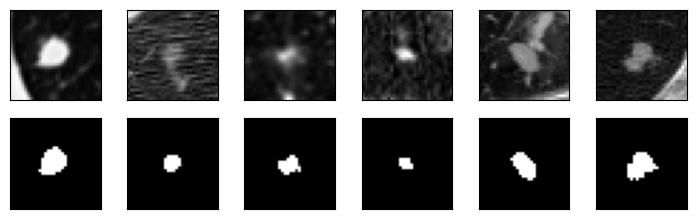

<Figure size 640x480 with 0 Axes>

In [64]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)    
    plt.imshow(data_train[i].reshape(nsize,nsize,1))
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
    # display reconstruction
    ax = plt.subplot(3, 20, 1*20 +i+ 1)    
    plt.imshow(autoencoder_imgs[i].reshape(nsize,nsize,1))    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()
plt.tight_layout()

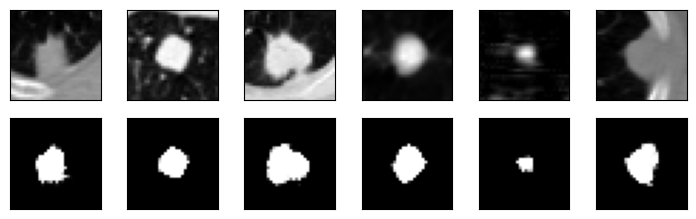

In [66]:
plt.figure(figsize=(30, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_test[i].reshape(nsize,nsize,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)       
    
    # display reconstruction
    ax = plt.subplot(3, 20, 1*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(nsize,nsize,1))
    plt.gray() 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

## PCA

In [77]:
labels_text_test = pd.DataFrame(label_test).replace({'0': "MF1", '1': "MF2",'2': "MF3"})
labels_text_test.shape

## flatten data
encoder_embds_flatten = encoder_embds.reshape(encoder_embds.shape[0], -1)
encoder_embds_test_flatten = encoder_embds_test.reshape(encoder_embds_test.shape[0], -1)

print('Encoder embds flatten shape: ', encoder_embds_flatten.shape)
print('Encoder embds test flatten shape: ', encoder_embds_test_flatten.shape)

Encoder embds flatten shape:  (1356, 2048)
Encoder embds test flatten shape:  (107, 2048)


In [78]:
pca_data_test = PCA(n_components=2)

PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test_flatten)
PCA_2dim_test.shape

(107, 2)

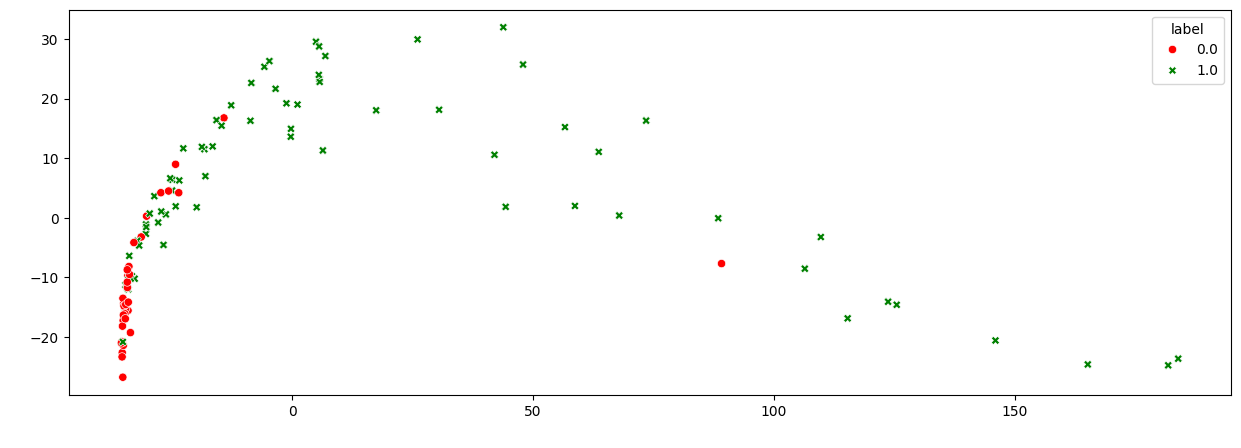

In [79]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={0: "red", 1: "green"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

In [80]:
pca_data_test_3D = PCA(n_components=3)
PCA_3dim_test = pca_data_test_3D.fit_transform(encoder_embds_test_flatten)
PCA_3dim_test.shape

(107, 3)

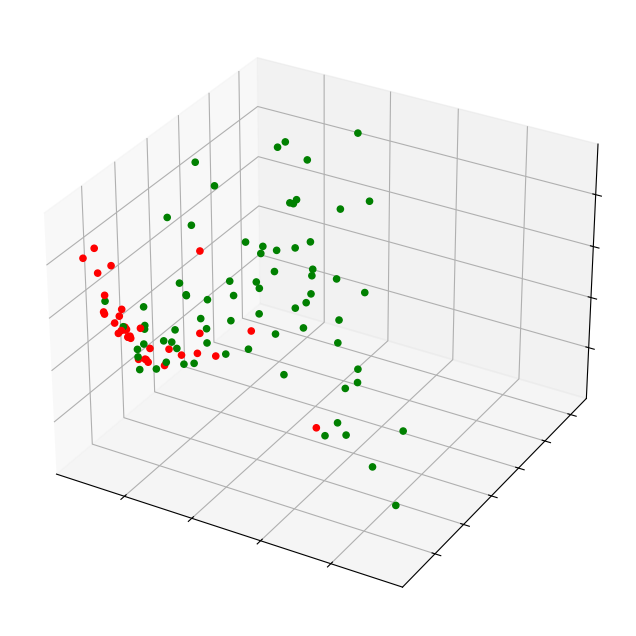

In [81]:
from matplotlib.colors import ListedColormap
data_img_pca_test_3D = pd.DataFrame()                 
data_img_pca_test_3D['x'] = PCA_3dim_test[:,0]
data_img_pca_test_3D['y'] = PCA_3dim_test[:,1]
data_img_pca_test_3D['Z'] = PCA_3dim_test[:,2]
data_img_pca_test_3D['label'] = pd.DataFrame(labels_text_test)

# 3D scatterplot using matplotlib
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

x = data_img_pca_test_3D['x']
y = data_img_pca_test_3D['y']
z = data_img_pca_test_3D['Z']
mycmap = ListedColormap(["red", "green"])
ax.scatter(x, y, z, c =  data_img_pca_test_3D['label'].replace({0: 0, 1: 1}), marker='o', cmap=mycmap, s=20, alpha=1)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_zlabel(' ')
ax.grid(True)
plt.show()

## T-sne

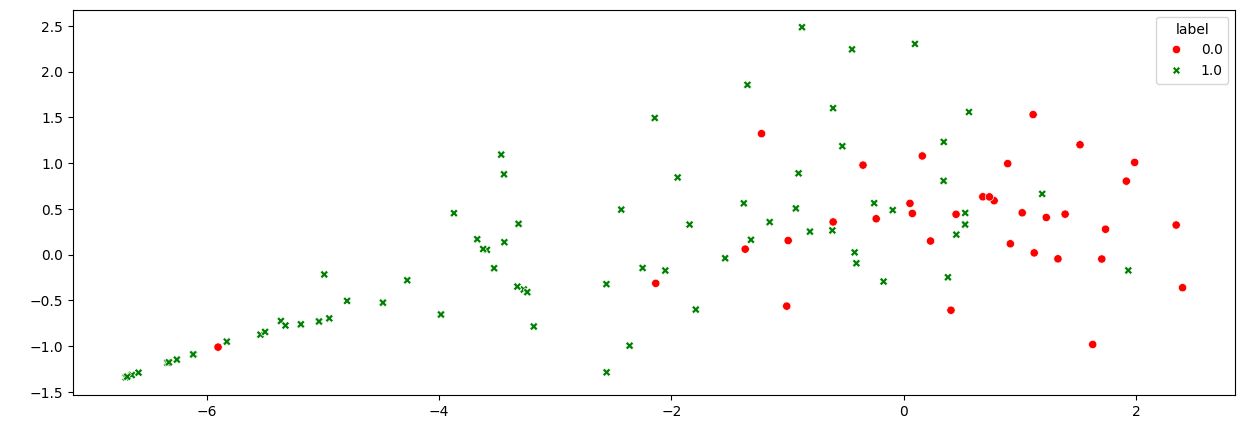

In [82]:
## T-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(encoder_embds_test_flatten)
tsne_results.shape

data_img_tsne_test = pd.DataFrame()
data_img_tsne_test['x'] = tsne_results[:,0]
data_img_tsne_test['y'] = tsne_results[:,1]
data_img_tsne_test['label'] = pd.DataFrame(labels_text_test)

sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_tsne_test.x,y=data_img_tsne_test.y,hue='label',data=data_img_tsne_test,style='label',
            sizes=(60, 100), alpha=1, palette={0: "red", 1: "green"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()


# Machine learning classification of embeddings

In [99]:
## validación cruzada con Random Forest
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# Usar KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# clasificador
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Listas para guardar los resultados
accuracy = []
roc = []
recall = []
precision = []
auc = []

## para la clase 0
f1_0 = []
accuracy_0 = []
roc_0 = []
recall_0 = []
precision_0 = []

## para la clase 1
f1_1 = []
accuracy_1 = []
roc_1 = []
recall_1 = []
precision_1 = []

# Iterar sobre los splits de test y train
for train_index, test_index in kf.split(encoder_embds_test_flatten):
    X_train = encoder_embds_flatten[train_index]
    y_train = label_train[train_index]
    X_test = encoder_embds_test_flatten[:]
    y_test = label_test[:]
    
    # Entrenar el clasificador
    clf.fit(X_train, y_train)
    
    # Predecir
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    ## save results from the report
    accuracy.append(report['accuracy'])    
    recall.append(report['weighted avg']['recall'])
    precision.append(report['weighted avg']['precision'])
    auc.append(roc_auc_score(y_test, y_pred))
    
    ## clase 0
    f1_0.append(report['0.0']['f1-score'])
    accuracy_0.append(report['0.0']['recall'])
    recall_0.append(report['0.0']['recall'])
    precision_0.append(report['0.0']['precision'])
    
    ## clase 1
    f1_1.append(report['1.0']['f1-score'])
    accuracy_1.append(report['1.0']['recall'])
    recall_1.append(report['1.0']['recall'])
    precision_1.append(report['1.0']['precision'])  
    
    
    
## imrpimir resultados con 4 cifras significativas y varianza
print('Accuracy: {:.4f} +/- {:.4f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Recall: {:.4f} +/- {:.4f}'.format(np.mean(recall), np.std(recall)))
print('Precision: {:.4f} +/- {:.4f}'.format(np.mean(precision), np.std(precision)))
print('AUC: {:.4f} +/- {:.4f}'.format(np.mean(auc), np.std(auc)))
      
print('Accuracy clase 0: {:.4f} +/- {:.4f}'.format(np.mean(accuracy_0), np.std(accuracy_0)))
print('Recall clase 0: {:.4f} +/- {:.4f}'.format(np.mean(recall_0), np.std(recall_0)))
print('Precision clase 0: {:.4f} +/- {:.4f}'.format(np.mean(precision_0), np.std(precision_0)))
      
print('Accuracy clase 1: {:.4f} +/- {:.4f}'.format(np.mean(accuracy_1), np.std(accuracy_1)))
print('Recall clase 1: {:.4f} +/- {:.4f}'.format(np.mean(recall_1), np.std(recall_1)))
print('Precision clase 1: {:.4f} +/- {:.4f}'.format(np.mean(precision_1), np.std(precision_1)))


Accuracy: 0.8299 +/- 0.0070
Recall: 0.8299 +/- 0.0070
Precision: 0.8286 +/- 0.0078
AUC: 0.7968 +/- 0.0161
Accuracy clase 0: 0.7059 +/- 0.0456
Recall clase 0: 0.7059 +/- 0.0456
Precision clase 0: 0.7466 +/- 0.0186
Accuracy clase 1: 0.8877 +/- 0.0160
Recall clase 1: 0.8877 +/- 0.0160
Precision clase 1: 0.8668 +/- 0.0154


In [100]:
## validación cruzada con Decision Tree
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

# Usar KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# clasificador
clf = DecisionTreeClassifier(random_state=42)

# Listas para guardar los resultados
accuracy = []
roc = []
recall = []
precision = []
auc = []

## para la clase 0
f1_0 = []
accuracy_0 = []
roc_0 = []
recall_0 = []
precision_0 = []

## para la clase 1
f1_1 = []
accuracy_1 = []
roc_1 = []
recall_1 = []
precision_1 = []

# Iterar sobre los splits de test y train
for train_index, test_index in kf.split(encoder_embds_test_flatten):
    X_train = encoder_embds_flatten[train_index]
    y_train = label_train[train_index]
    X_test = encoder_embds_test_flatten[:]
    y_test = label_test[:]
    
    # Entrenar el clasificador
    clf.fit(X_train, y_train)
    
    # Predecir
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    ## save results from the report
    accuracy.append(report['accuracy'])    
    recall.append(report['weighted avg']['recall'])
    precision.append(report['weighted avg']['precision'])
    auc.append(roc_auc_score(y_test, y_pred))
    
    ## clase 0
    f1_0.append(report['0.0']['f1-score'])
    accuracy_0.append(report['0.0']['recall'])
    recall_0.append(report['0.0']['recall'])
    precision_0.append(report['0.0']['precision'])
    
    ## clase 1
    f1_1.append(report['1.0']['f1-score'])
    accuracy_1.append(report['1.0']['recall'])
    recall_1.append(report['1.0']['recall'])
    precision_1.append(report['1.0']['precision'])  
    
    
    
## imrpimir resultados con 4 cifras significativas y varianza
print('Accuracy: {:.4f} +/- {:.4f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Recall: {:.4f} +/- {:.4f}'.format(np.mean(recall), np.std(recall)))
print('Precision: {:.4f} +/- {:.4f}'.format(np.mean(precision), np.std(precision)))
print('AUC: {:.4f} +/- {:.4f}'.format(np.mean(auc), np.std(auc)))
      
print('Accuracy clase 0: {:.4f} +/- {:.4f}'.format(np.mean(accuracy_0), np.std(accuracy_0)))
print('Recall clase 0: {:.4f} +/- {:.4f}'.format(np.mean(recall_0), np.std(recall_0)))
print('Precision clase 0: {:.4f} +/- {:.4f}'.format(np.mean(precision_0), np.std(precision_0)))
      
print('Accuracy clase 1: {:.4f} +/- {:.4f}'.format(np.mean(accuracy_1), np.std(accuracy_1)))
print('Recall clase 1: {:.4f} +/- {:.4f}'.format(np.mean(recall_1), np.std(recall_1)))
print('Precision clase 1: {:.4f} +/- {:.4f}'.format(np.mean(precision_1), np.std(precision_1)))

Accuracy: 0.7682 +/- 0.0292
Recall: 0.7682 +/- 0.0292
Precision: 0.7721 +/- 0.0254
AUC: 0.7374 +/- 0.0280
Accuracy clase 0: 0.6529 +/- 0.0471
Recall clase 0: 0.6529 +/- 0.0471
Precision clase 0: 0.6350 +/- 0.0541
Accuracy clase 1: 0.8219 +/- 0.0416
Recall clase 1: 0.8219 +/- 0.0416
Precision clase 1: 0.8359 +/- 0.0184


In [101]:
## validación cruzada con support vector machine
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import KFold
from sklearn.svm import SVC

# Usar KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# clasificador
clf = SVC(random_state=42)

# Listas para guardar los resultados
accuracy = []
roc = []
recall = []
precision = []
auc = []

## para la clase 0
f1_0 = []
accuracy_0 = []
roc_0 = []
recall_0 = []
precision_0 = []

## para la clase 1
f1_1 = []
accuracy_1 = []
roc_1 = []
recall_1 = []
precision_1 = []

# Iterar sobre los splits de test y train
for train_index, test_index in kf.split(encoder_embds_test_flatten):
    X_train = encoder_embds_flatten[train_index]
    y_train = label_train[train_index]
    X_test = encoder_embds_test_flatten[:]
    y_test = label_test[:]
    
    # Entrenar el clasificador
    clf.fit(X_train, y_train)
    
    # Predecir
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    ## save results from the report
    accuracy.append(report['accuracy'])    
    recall.append(report['weighted avg']['recall'])
    precision.append(report['weighted avg']['precision'])
    auc.append(roc_auc_score(y_test, y_pred))
    
    ## clase 0
    f1_0.append(report['0.0']['f1-score'])
    accuracy_0.append(report['0.0']['recall'])
    recall_0.append(report['0.0']['recall'])
    precision_0.append(report['0.0']['precision'])
    
    ## clase 1
    f1_1.append(report['1.0']['f1-score'])
    accuracy_1.append(report['1.0']['recall'])
    recall_1.append(report['1.0']['recall'])
    precision_1.append(report['1.0']['precision'])  
    
    
    
## imrpimir resultados con 4 cifras significativas y varianza
print('Accuracy: {:.4f} +/- {:.4f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Recall: {:.4f} +/- {:.4f}'.format(np.mean(recall), np.std(recall)))
print('Precision: {:.4f} +/- {:.4f}'.format(np.mean(precision), np.std(precision)))
print('AUC: {:.4f} +/- {:.4f}'.format(np.mean(auc), np.std(auc)))
      
print('Accuracy clase 0: {:.4f} +/- {:.4f}'.format(np.mean(accuracy_0), np.std(accuracy_0)))
print('Recall clase 0: {:.4f} +/- {:.4f}'.format(np.mean(recall_0), np.std(recall_0)))
print('Precision clase 0: {:.4f} +/- {:.4f}'.format(np.mean(precision_0), np.std(precision_0)))
      
print('Accuracy clase 1: {:.4f} +/- {:.4f}'.format(np.mean(accuracy_1), np.std(accuracy_1)))
print('Recall clase 1: {:.4f} +/- {:.4f}'.format(np.mean(recall_1), np.std(recall_1)))
print('Precision clase 1: {:.4f} +/- {:.4f}'.format(np.mean(precision_1), np.std(precision_1)))

Accuracy: 0.8318 +/- 0.0084
Recall: 0.8318 +/- 0.0084
Precision: 0.8335 +/- 0.0060
AUC: 0.8091 +/- 0.0058
Accuracy clase 0: 0.7471 +/- 0.0235
Recall clase 0: 0.7471 +/- 0.0235
Precision clase 0: 0.7314 +/- 0.0253
Accuracy clase 1: 0.8712 +/- 0.0205
Recall clase 1: 0.8712 +/- 0.0205
Precision clase 1: 0.8811 +/- 0.0081
